<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S12/Assignment_A/tinyimagenet_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
! git clone https://github.com/anuragal/deep-learning deep_learning
! ls 'deep_learning/tiny-imagenet-200/'

fatal: destination path 'deep_learning' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


In [4]:
! cd 'deep_learning' && git pull

Already up to date.


## Model

In [5]:
!pip install albumentations==0.4.5

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#Load Resnet18
model = models.resnet18()

#Finetune Final few layers to adjust for tiny imagenet input
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 200
model = model.to(device)

summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [

## Run the Model

In [6]:
%matplotlib inline

In [7]:
import torch.nn as nn

from deep_learning.S12.Assignment_A.dataloader import ImageData
from deep_learning.S12.Assignment_A.datamodel import DataModel
from deep_learning.S12.Assignment_A.optimizer import OptimizerFactory

from torch.optim.lr_scheduler import OneCycleLR

dataset_path = 'deep_learning/tiny-imagenet-200/'
# Loading data and transforming it
img_data = ImageData()

# Choose from "albumentations" or "pytorch". Default is "pytorch"
img_data.load_TINY_IMAGENET(dataset_path, "albumentations")

criterion = nn.CrossEntropyLoss()

# optimizer can be choose from "SGD" & "Adam"
optim_sgd = OptimizerFactory("SGD")
optimizer = optim_sgd.load(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

dm = DataModel(img_data, criterion, optimizer, None, num_of_epochs = 50, cal_misclassified = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
  pip install torch-lr-finder -v --global-option="amp"


CUDA Available? True
{51: 76828, 11: 76925, 113: 76825, 176: 76970, 45: 76764, 65: 76972, 4: 76852, 24: 76885, 175: 76613, 187: 76966, 32: 76951, 18: 76889, 160: 76975, 148: 76385, 39: 76904, 181: 76989, 63: 76801, 166: 76864, 64: 76930, 31: 76700, 46: 76618, 169: 76942, 104: 76984, 142: 76397, 120: 76878, 50: 76445, 12: 76750, 193: 76943, 59: 76941, 198: 76839, 80: 76785, 177: 76990, 15: 76873, 108: 76959, 0: 76436, 155: 76965, 107: 76986, 38: 76960, 79: 76732, 139: 76891, 138: 76863, 184: 76874, 145: 76414, 22: 76705, 119: 76835, 44: 76745, 174: 76918, 30: 76958, 102: 76931, 192: 76914, 144: 76702, 72: 76919, 152: 76854, 105: 76549, 153: 76992, 154: 76915, 157: 76922, 90: 76867, 173: 76939, 67: 76956, 37: 76726, 167: 76982, 118: 76850, 147: 76882, 126: 76544, 137: 76265, 25: 76818, 127: 76765, 112: 76620, 17: 76944, 163: 76902, 5: 76186, 151: 76978, 42: 76927, 180: 76352, 158: 76894, 7: 76898, 123: 76675, 57: 76999, 101: 76968, 150: 76838, 69: 76995, 170: 76964, 188: 76993, 156: 7686

### Find LR Max

In [8]:
# lr = dm.find_lr_max(model, device)

### LR Max

In [9]:
lr = 0.0254
print(lr)

0.0254



## Run Model

In [10]:
dm.optimizer = optim_sgd.load(params=model.parameters(), lr=lr/10, momentum=0.9, weight_decay=0.0005)

# training the dataset and then running test
scheduler = OneCycleLR(dm.optimizer, 
                       max_lr=lr, 
                       epochs=50, 
                       steps_per_epoch = len(img_data.trainloader) + 1, 
                       div_factor=10,
                       final_div_factor=100.0,
                       pct_start=0.2
                      )
dm.schedular = scheduler
dm.run_model(model, device)

  0%|          | 0/301 [00:00<?, ?it/s]


EPOCH: 1


  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 1884/33000 (5.71%)

Learning Rate: 0.003096

EPOCH: 2


Loss=4.271520614624023 Batch_id=300 Accuracy=8.52: 100%|██████████| 301/301 [00:59<00:00,  5.02it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 3633/33000 (11.01%)

Learning Rate: 0.004710

EPOCH: 3


Loss=3.689910650253296 Batch_id=300 Accuracy=14.51: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 5201/33000 (15.76%)

Learning Rate: 0.007226

EPOCH: 4


Loss=3.5860190391540527 Batch_id=300 Accuracy=19.37: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 6538/33000 (19.81%)

Learning Rate: 0.010397

EPOCH: 5


Loss=3.3524794578552246 Batch_id=300 Accuracy=23.26: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 7555/33000 (22.89%)

Learning Rate: 0.013916

EPOCH: 6


Loss=3.1852903366088867 Batch_id=300 Accuracy=26.86: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 8186/33000 (24.81%)

Learning Rate: 0.017441

EPOCH: 7


Loss=2.689701557159424 Batch_id=300 Accuracy=29.89: 100%|██████████| 301/301 [01:00<00:00,  5.01it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 9300/33000 (28.18%)

Learning Rate: 0.020628

EPOCH: 8


Loss=3.037261724472046 Batch_id=300 Accuracy=32.84: 100%|██████████| 301/301 [00:59<00:00,  5.02it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 9194/33000 (27.86%)

Learning Rate: 0.023166

EPOCH: 9


Loss=2.6462039947509766 Batch_id=300 Accuracy=35.78: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9775/33000 (29.62%)

Learning Rate: 0.024810

EPOCH: 10


Loss=2.6603033542633057 Batch_id=300 Accuracy=38.55: 100%|██████████| 301/301 [01:00<00:00,  5.01it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 10640/33000 (32.24%)

Learning Rate: 0.025399

EPOCH: 11


Loss=2.4035732746124268 Batch_id=300 Accuracy=41.36: 100%|██████████| 301/301 [01:00<00:00,  4.97it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 10650/33000 (32.27%)

Learning Rate: 0.025363

EPOCH: 12


Loss=2.277160167694092 Batch_id=300 Accuracy=44.42: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 10782/33000 (32.67%)

Learning Rate: 0.025249

EPOCH: 13


Loss=2.0939884185791016 Batch_id=300 Accuracy=46.91: 100%|██████████| 301/301 [00:59<00:00,  5.03it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 10692/33000 (32.40%)

Learning Rate: 0.025059

EPOCH: 14


Loss=1.7950313091278076 Batch_id=300 Accuracy=49.37: 100%|██████████| 301/301 [01:00<00:00,  5.01it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10812/33000 (32.76%)

Learning Rate: 0.024792

EPOCH: 15


Loss=2.0284736156463623 Batch_id=300 Accuracy=52.12: 100%|██████████| 301/301 [00:59<00:00,  5.03it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 11395/33000 (34.53%)

Learning Rate: 0.024452

EPOCH: 16


Loss=1.8995786905288696 Batch_id=300 Accuracy=54.92: 100%|██████████| 301/301 [01:00<00:00,  5.01it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10961/33000 (33.22%)

Learning Rate: 0.024040

EPOCH: 17


Loss=1.8756283521652222 Batch_id=300 Accuracy=57.34: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 10759/33000 (32.60%)

Learning Rate: 0.023558

EPOCH: 18


Loss=1.7740073204040527 Batch_id=300 Accuracy=60.15: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 11025/33000 (33.41%)

Learning Rate: 0.023010

EPOCH: 19


Loss=1.808054804801941 Batch_id=300 Accuracy=62.77: 100%|██████████| 301/301 [01:01<00:00,  4.93it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 11469/33000 (34.75%)

Learning Rate: 0.022399

EPOCH: 20


Loss=1.4606024026870728 Batch_id=300 Accuracy=65.55: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 11431/33000 (34.64%)

Learning Rate: 0.021728

EPOCH: 21


Loss=1.2558246850967407 Batch_id=300 Accuracy=67.79: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 11579/33000 (35.09%)

Learning Rate: 0.021003

EPOCH: 22


Loss=1.2847237586975098 Batch_id=300 Accuracy=70.59: 100%|██████████| 301/301 [01:00<00:00,  4.95it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 11410/33000 (34.58%)

Learning Rate: 0.020226

EPOCH: 23


Loss=1.1490827798843384 Batch_id=300 Accuracy=73.16: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 11853/33000 (35.92%)

Learning Rate: 0.019404

EPOCH: 24


Loss=1.0411981344223022 Batch_id=300 Accuracy=75.29: 100%|██████████| 301/301 [01:00<00:00,  4.97it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 11723/33000 (35.52%)

Learning Rate: 0.018540

EPOCH: 25


Loss=0.885866105556488 Batch_id=300 Accuracy=77.16: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 11613/33000 (35.19%)

Learning Rate: 0.017641

EPOCH: 26


Loss=0.862071692943573 Batch_id=300 Accuracy=79.64: 100%|██████████| 301/301 [01:00<00:00,  4.95it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 11627/33000 (35.23%)

Learning Rate: 0.016712

EPOCH: 27


Loss=0.7521618604660034 Batch_id=300 Accuracy=81.81: 100%|██████████| 301/301 [01:01<00:00,  4.93it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 11842/33000 (35.88%)

Learning Rate: 0.015758

EPOCH: 28


Loss=0.6484954953193665 Batch_id=300 Accuracy=83.71: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 11751/33000 (35.61%)

Learning Rate: 0.014785

EPOCH: 29


Loss=0.6629931926727295 Batch_id=300 Accuracy=85.21: 100%|██████████| 301/301 [00:59<00:00,  5.05it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 11866/33000 (35.96%)

Learning Rate: 0.013800

EPOCH: 30


Loss=0.5332911014556885 Batch_id=300 Accuracy=87.35: 100%|██████████| 301/301 [00:59<00:00,  5.02it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 11729/33000 (35.54%)

Learning Rate: 0.012808

EPOCH: 31


Loss=0.5529597401618958 Batch_id=300 Accuracy=88.85: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 11911/33000 (36.09%)

Learning Rate: 0.011816

EPOCH: 32


Loss=0.40932705998420715 Batch_id=300 Accuracy=90.48: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 12217/33000 (37.02%)

Learning Rate: 0.010829

EPOCH: 33


Loss=0.3430367708206177 Batch_id=300 Accuracy=92.04: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 12341/33000 (37.40%)

Learning Rate: 0.009854

EPOCH: 34


Loss=0.3005155622959137 Batch_id=300 Accuracy=93.13: 100%|██████████| 301/301 [01:00<00:00,  5.01it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 12404/33000 (37.59%)

Learning Rate: 0.008896

EPOCH: 35


Loss=0.27533525228500366 Batch_id=300 Accuracy=94.28: 100%|██████████| 301/301 [01:00<00:00,  4.97it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 12265/33000 (37.17%)

Learning Rate: 0.007961

EPOCH: 36


Loss=0.23526352643966675 Batch_id=300 Accuracy=95.50: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 12660/33000 (38.36%)

Learning Rate: 0.007056

EPOCH: 37


Loss=0.1727883219718933 Batch_id=300 Accuracy=96.51: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 12767/33000 (38.69%)

Learning Rate: 0.006185

EPOCH: 38


Loss=0.16712817549705505 Batch_id=300 Accuracy=97.19: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 12884/33000 (39.04%)

Learning Rate: 0.005354

EPOCH: 39


Loss=0.16793660819530487 Batch_id=300 Accuracy=97.70: 100%|██████████| 301/301 [01:00<00:00,  4.96it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 12953/33000 (39.25%)

Learning Rate: 0.004569

EPOCH: 40


Loss=0.10456466674804688 Batch_id=300 Accuracy=98.17: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 13139/33000 (39.82%)

Learning Rate: 0.003833

EPOCH: 41


Loss=0.08795591443777084 Batch_id=300 Accuracy=98.59: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 13153/33000 (39.86%)

Learning Rate: 0.003151

EPOCH: 42


Loss=0.07363592088222504 Batch_id=300 Accuracy=98.93: 100%|██████████| 301/301 [01:01<00:00,  4.93it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 13207/33000 (40.02%)

Learning Rate: 0.002529

EPOCH: 43


Loss=0.08267369121313095 Batch_id=300 Accuracy=99.09: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 13227/33000 (40.08%)

Learning Rate: 0.001968

EPOCH: 44


Loss=0.06348401308059692 Batch_id=300 Accuracy=99.26: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 13429/33000 (40.69%)

Learning Rate: 0.001473

EPOCH: 45


Loss=0.045641541481018066 Batch_id=300 Accuracy=99.31: 100%|██████████| 301/301 [01:00<00:00,  5.00it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 13305/33000 (40.32%)

Learning Rate: 0.001047

EPOCH: 46


Loss=0.040203820914030075 Batch_id=300 Accuracy=99.40: 100%|██████████| 301/301 [01:00<00:00,  4.99it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 13389/33000 (40.57%)

Learning Rate: 0.000693

EPOCH: 47


Loss=0.060141414403915405 Batch_id=300 Accuracy=99.45: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 13368/33000 (40.51%)

Learning Rate: 0.000412

EPOCH: 48


Loss=0.04707864671945572 Batch_id=300 Accuracy=99.52: 100%|██████████| 301/301 [01:00<00:00,  5.02it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 13387/33000 (40.57%)

Learning Rate: 0.000207

EPOCH: 49


Loss=0.04431566223502159 Batch_id=300 Accuracy=99.53: 100%|██████████| 301/301 [01:00<00:00,  5.02it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 13437/33000 (40.72%)

Learning Rate: 0.000078

EPOCH: 50


Loss=0.035279445350170135 Batch_id=300 Accuracy=99.55: 100%|██████████| 301/301 [01:00<00:00,  4.98it/s]



Test set: Average loss: 0.0119, Accuracy: 13456/33000 (40.78%)

Learning Rate: 0.000026


## Plotting Test & Train Accuracy

[2.7194805194805194, 8.522077922077923, 14.514285714285714, 19.366233766233766, 23.258441558441557, 26.857142857142858, 29.887012987012987, 32.84155844155844, 35.77792207792208, 38.54935064935065, 41.36363636363637, 44.41558441558441, 46.91168831168831, 49.36753246753247, 52.12077922077922, 54.923376623376626, 57.34415584415584, 60.14935064935065, 62.77012987012987, 65.54935064935064, 67.78571428571429, 70.5909090909091, 73.16233766233766, 75.2909090909091, 77.15714285714286, 79.64025974025974, 81.81168831168831, 83.70519480519481, 85.21038961038961, 87.34935064935065, 88.85324675324675, 90.47922077922078, 92.03896103896103, 93.12857142857143, 94.28441558441558, 95.5, 96.50649350649351, 97.1922077922078, 97.6974025974026, 98.16753246753247, 98.58701298701298, 98.93246753246753, 99.09480519480519, 99.26233766233766, 99.31168831168831, 99.4012987012987, 99.44675324675325, 99.52207792207793, 99.52727272727273, 99.54545454545455]
[5.709090909090909, 11.00909090909091, 15.76060606060606, 19

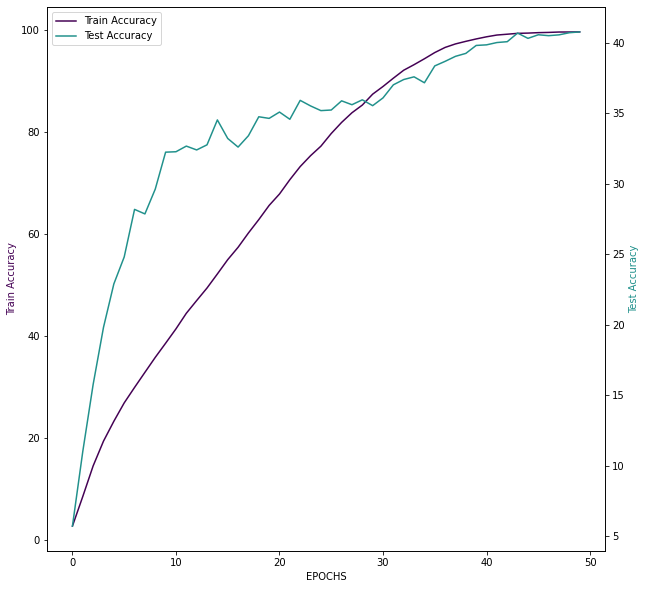

In [11]:
dm.plot_test_train_accuracy()

## Plotting Validation Accuracy

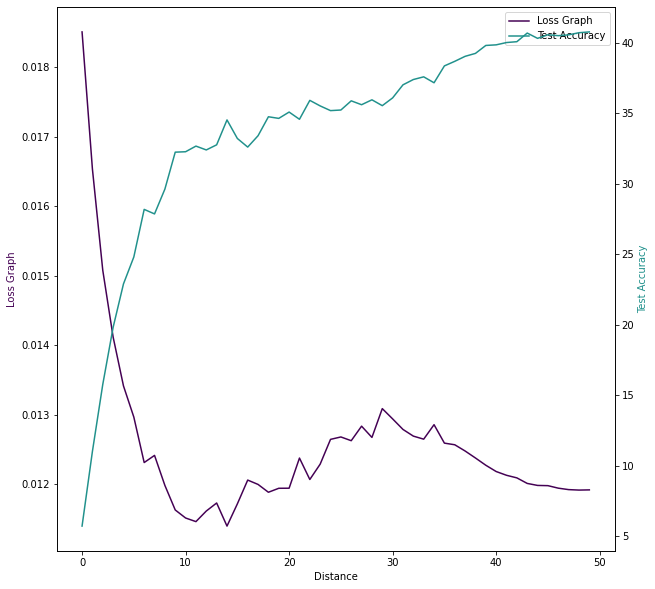

In [12]:
dm.plot_loss_accuracy()